nt=0


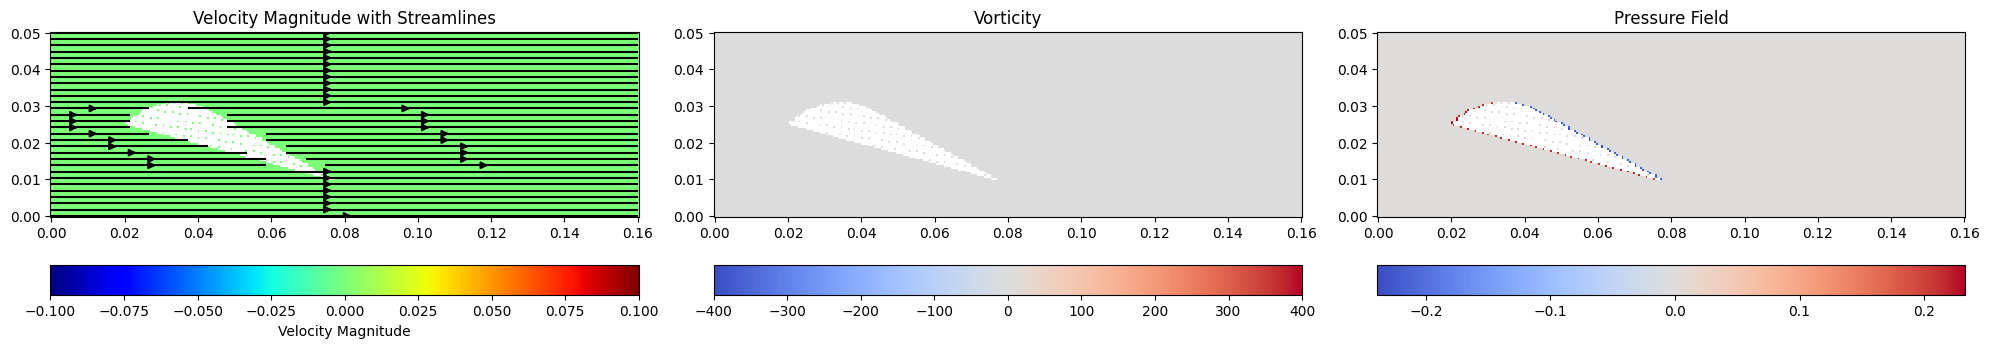

nt=20


C:\Users\green\PycharmProjects\Myprofile\.venv\Lib\site-packages\matplotlib\streamplot.py:626: RuntimeWarning: overflow encountered in scalar divide
  dsy = (np.float64(ny - 1 - yi)) / np.float64(cy)
C:\Users\green\PycharmProjects\Myprofile\.venv\Lib\site-packages\matplotlib\streamplot.py:624: RuntimeWarning: overflow encountered in scalar divide
  dsy = yi / -cy
C:\Users\green\PycharmProjects\Myprofile\.venv\Lib\site-packages\matplotlib\streamplot.py:605: RuntimeWarning: overflow encountered in scalar divide
  ds = min(maxds, 0.85 * ds * (maxerror / error) ** 0.5)


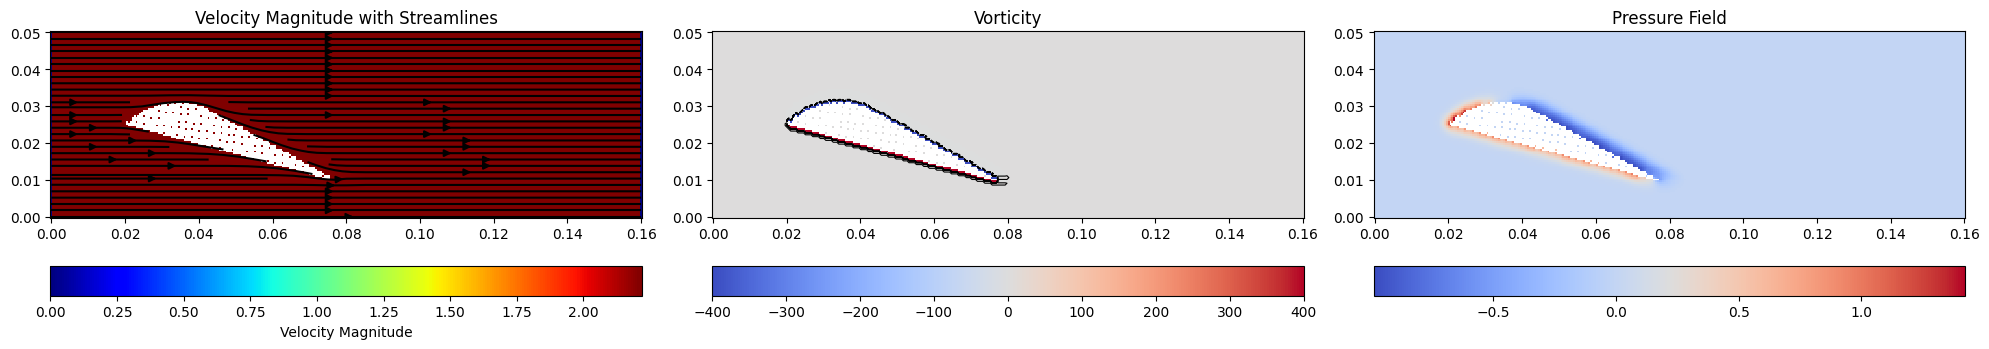

KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter

n = 2   #格子点を増やす
imax = 160 * n  #x方向格子点数
jmax = 50 * n  #y方向格子点数
nmax = 100 #何ステップまで計算するか
interval = 20 #描画する間隔

mu0 = 1.7894e-5 #標準状態における粘性係数
T0 = 273.15 + 15 #標準状態における温度
S = 110.4   #サザーランドの定数
T = 273.15 - 40 #上空での温度
rho = 1.23   #密度
#サザーランドの公式より上空での空気の粘性係数を求める
mu = mu0*((T/T0)**(3/2)*(T0+S)/(T+S)) #粘性係数

uxin = 2.22    #入口x方向流速
uyin = 0    #入口y方向流速
dt = 0.0001 #時間刻み
dx = 0.001 / n  #格子幅（x、y方向で同等）
x = np.linspace(0,dx*imax,imax)    #格子生成
y = np.linspace(0,dx*jmax,jmax)    #格子生成

#各物理量を0で初期化
ux = np.zeros([jmax,imax])
uy = np.zeros([jmax,imax])
umag = np.zeros([jmax,imax])
omega = np.zeros([jmax,imax])
p = np.zeros([jmax,imax])
pnew = np.zeros([jmax,imax])
solid = np.zeros([jmax,imax])


#飛行機の翼の断面図を固体部分に設定する
#直線と円を用いて表現する
origin_x = 0.02
origin_y = 0.025
delta = 0.01

#円の中心を設定
x_center =  7/4 * delta # 円の中心（X方向）
y_center = - delta     # 円の中心（Y方向）
radius = np.sqrt(65) / 4  * delta             # 円の半径
a, b = 2 * delta , delta
length = 6 * delta
#固体部分を設定
#二つの直線と一つの円の内部にある格子点を1と設定する。
for j in range(jmax):
  for i in range(imax):
    if 0 <= (x[i] -origin_x)<= a:
      if 0 <= (y[j] - origin_y) <= y_center + np.sqrt(radius**2 - ((x[i] - origin_x) - x_center)**2):
          solid[j][i] = 1

    elif a < (x[i] -origin_x) <= length:
      if 0 <= (y[j] - origin_y) <= 3 / 2 * delta - (x[i] - origin_x) / 4:
          solid[j][i] = 1

#次にこの翼の断面を任意の角度で回転できるようにする
# 角度をラジアンに変換

alpha = -15     #任意の角度を入れる
theta = np.radians(alpha)

# 回転行列の成分
cos_theta = np.cos(theta)
sin_theta = np.sin(theta)

# 新しい solid 配列（回転後）
rotated_solid = np.zeros_like(solid)

for j in range(jmax):
    for i in range(imax):
        if solid[j][i] == 1:
            # 現在の格子点の座標
            x_old = x[i]
            y_old = y[j]

            # 原点を中心に回転するために移動
            x_prime = x_old - origin_x
            y_prime = y_old - origin_y

            # 回転行列を適用
            x_rotated = x_prime * cos_theta - y_prime * sin_theta
            y_rotated = x_prime * sin_theta + y_prime * cos_theta

            # 元の位置に戻す
            x_new = x_rotated + origin_x
            y_new = y_rotated + origin_y

            # 最も近い格子点を探して更新
            i_new = np.argmin(np.abs(x - x_new))
            j_new = np.argmin(np.abs(y - y_new))

            if 0 <= i_new < imax and 0 <= j_new < jmax:
                rotated_solid[j_new][i_new] = 1

# `solid` を回転後のものに置き換え
solid = rotated_solid


#流速uの移流拡散方程式(ナビエストークス方程式)
for j in range(0,jmax):
    for i in range(0,int(imax)):
        ux[j][i] = uxin
        uy[j][i] = uyin

X,Y = np.meshgrid(x,y)
for nt in range(0,nmax + 1): #時間ループ
    uxold = ux.copy()
    uyold = uy.copy()
    for j in range(1,jmax-1):
        for i in range(1,imax-1):
            # 一次風上差分（流速が0の場合は中心差分を使用）
            duxdx = (uxold[j, i] - uxold[j, i - 1]) / dx if uxold[j, i] > 0 else \
                (uxold[j, i + 1] - uxold[j, i]) / dx if uxold[j, i] < 0 else \
                    (uxold[j, i + 1] - uxold[j, i - 1]) / (2 * dx)
            duxdy = (uxold[j, i] - uxold[j - 1, i]) / dx if uyold[j, i] > 0 else \
                (uxold[j + 1, i] - uxold[j, i]) / dx if uyold[j, i] < 0 else \
                    (uxold[j + 1, i] - uxold[j - 1, i]) / (2 * dx)
            duydx = (uyold[j, i] - uyold[j, i - 1]) / dx if uxold[j, i] > 0 else \
                (uyold[j, i + 1] - uyold[j, i]) / dx if uxold[j, i] < 0 else \
                    (uyold[j, i + 1] - uyold[j, i - 1]) / (2 * dx)
            duydy = (uyold[j, i] - uyold[j - 1, i]) / dx if uyold[j, i] > 0 else \
                (uyold[j + 1, i] - uyold[j, i]) / dx if uyold[j, i] < 0 else \
                    (uyold[j + 1, i] - uyold[j - 1, i]) / (2 * dx)
            # X方向速度 ux の更新
            d2uxdx2_x = (ux[j, i + 1] - 2 * ux[j, i] + ux[j, i - 1]) / (dx ** 2)
            d2uxdy2_y = (ux[j + 1, i] - 2 * ux[j, i] + ux[j - 1, i]) / (dx ** 2)
            ux[j, i] = uxold[j, i] - dt * (uxold[j, i] * duxdx + uyold[j, i] * duxdy) \
                       - dt / rho * ((p[j, i + 1] - p[j, i - 1]) / (2 * dx)) \
                       + dt * mu / rho * (d2uxdx2_x + d2uxdy2_y)
            # Y方向速度 uy の更新
            d2uydx2_x = (uy[j, i + 1] - 2 * uy[j, i] + uy[j, i - 1]) / (dx ** 2)
            d2uydy2_y = (uy[j + 1, i] - 2 * uy[j, i] + uy[j - 1, i]) / (dx ** 2)
            uy[j, i] = uyold[j, i] - dt * (uxold[j, i] * duydx + uyold[j, i] * duydy) \
                       - dt / rho * ((p[j + 1, i] - p[j - 1, i]) / (2 * dx)) \
                       + dt * mu / rho * (d2uydx2_x + d2uydy2_y)
            # 流速の境界条件
        for j in range(0, jmax):
            ux[j][0] = uxin
            ux[j][imax - 1] = ux[j][imax - 2]
        for i in range(0, imax):
            ux[0][i] = ux[1][i]
            ux[jmax - 1][i] = ux[jmax - 2][i]

        for j in range(0, jmax):
            uy[j][0] = uyin
            uy[j][imax - 1] = uy[j][imax - 2]
        for i in range(0, imax):
            uy[0][i] = 0
            uy[jmax - 1][i] = 0
        uy[jmax - 1][imax - 1] = 0
        for j in range(1, jmax - 1):
            for i in range(1, imax - 1):
                if solid[j][i] == 1:
                    ux[j][i] = 0
                    uy[j][i] = 0

    for n in range(0,3):    #SOR法の反復回数を3回に設定
        for j in range(1,jmax-1):
            for i in range(1,imax-1):
                divergence = ((ux[j][i+1] - ux[j][i-1]) / (2 * dx) + (uy[j+1][i] - uy[j-1][i]) / (2 * dx))
                pnew[j][i] = 0.25 * (p[j][i+1] + p[j][i-1] + p[j+1][i] + p[j-1][i]) - 0.25 * dx * divergence * rho
        for j in range(1,jmax-1):
            for i in range(1,imax-1):
                p[j][i] = p[j][i] + 0.25 * (pnew[j][i] - p[j][i])
        for i in range(0,imax):
            p[0][i] = p[1][i]
            p[jmax-1][i] = p[jmax-2][i]
        for j in range(0,jmax):
            p[j][0] = p[j][1]
            p[j][imax-1] = 0

        # 固体セルの圧力を隣接する流体セルの平均値で設定
        for j in range(1, jmax - 1):
            for i in range(1, imax - 1):
                if solid[j, i] == 1:
                    neighbors = []
                    if solid[j, i - 1] == 0:
                        neighbors.append(p[j, i - 1])
                    if solid[j, i + 1] == 0:
                        neighbors.append(p[j, i + 1])
                    if solid[j - 1, i] == 0:
                        neighbors.append(p[j - 1, i])
                    if solid[j + 1, i] == 0:
                        neighbors.append(p[j + 1, i])
                    if neighbors:
                        p[j, i] = np.mean(neighbors)

        # 各ステップの可視化
    if nt % interval == 0:

        # 固体部分を白く上書きするためのマスク
        masked_umag = np.ma.masked_where(solid == 1, umag)
        masked_omega = np.ma.masked_where(solid == 1, omega)
        masked_p = np.ma.masked_where(solid == 1, p)

        for j in range(1, jmax - 1):
            for i in range(1, imax - 1):
                umag[j][i] = (ux[j][i] ** 2 + uy[j][i] ** 2) ** 0.5
                omega[j][i] = (uy[j][i + 1] - uy[j][i - 1]) / (2 * dx) - (ux[j + 1][i] - ux[j - 1][i]) / (2 * dx)

        print("nt=" + str(nt))

        # 図を作成
        fig = plt.figure(figsize=(20, 10))  # 必要に応じてサイズを変更
        spec = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1])  # 1行3列のGridSpec
        # 左側のpcolormesh
        ax1 = fig.add_subplot(spec[0, 0])
        c1 = ax1.pcolormesh(X, Y, masked_umag, cmap='jet', shading='auto')
        ax1.streamplot(X, Y, ux, uy, color='k', density=1.0)  # 流線の重ね書き
        ax1.set_title('Velocity Magnitude with Streamlines')
        ax1.set_aspect('equal')
        fig.colorbar(c1, ax=ax1, orientation='horizontal', pad=0.05, label='Velocity Magnitude')
        # 真ん中のコンター
        ax2 = fig.add_subplot(spec[0, 1])
        c2 = ax2.pcolormesh(X, Y, masked_omega, cmap='coolwarm', vmin=-400, vmax=400)
        ax2.set_title('Vorticity')
        ax2.set_aspect('equal')
        fig.colorbar(c2, ax=ax2, orientation='horizontal', pad=0.05)
        # 渦度場の等高線を追加
        levels = np.linspace(-400, 400, 21)  # 等高線の値の範囲と間隔
        contour = ax2.contour(X, Y, masked_omega, levels=levels, colors='k', linewidths=0.8)
        # 右のコンター（p）
        ax3 = fig.add_subplot(spec[0, 2])
        c3 = ax3.pcolormesh(X, Y, masked_p, cmap='coolwarm', shading='auto')
        ax3.set_title('Pressure Field')
        ax3.set_aspect('equal')
        fig.colorbar(c3, ax=ax3, orientation='horizontal', pad=0.05)

        # レイアウトを調整して表示
        plt.tight_layout()
        plt.show()

print("finished!")